### Import Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

### Import Dataset

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # Resize images to at least 224x224
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

dataset.transform = transform


In [ ]:
dataset = datasets.ImageFolder(r"/content/drive/MyDrive/dataset", transform=transform)

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 968
    Root location: /content/drive/MyDrive/dataset
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomCrop(size=(224, 224), padding=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
indices = list(range(len(dataset)))

In [ ]:
split = int(np.floor(0.80 * len(dataset)))  # train_size

In [ ]:
validation = int(np.floor(0.70 * split))  # validation

In [ ]:
print(0, validation, split, len(dataset))

0 541 774 968


In [ ]:
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")

length of train size :541
length of validation size :233
length of test size :427


In [ ]:
np.random.shuffle(indices)

### Split into Train and Test

In [ ]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

In [ ]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [ ]:
targets_size = len(dataset.class_to_idx)

### Model

### Original Modeling

In [ ]:
import torch
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self, output_size):
        super(LeNet, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 6, 5),  # Input: 3 channels, Output: 6 channels, Kernel size: 5
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Pooling: reduces dimensions
            nn.Conv2d(6, 16, 5),  # Input: 6 channels, Output: 16 channels, Kernel size: 5
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Pooling: reduces dimensions again
        )

        # Dynamically compute the size of the input to the first fully connected layer
        self.fc_input_size = self._get_conv_output_size()

        # Dense layers with added dropout
        self.fc1 = nn.Sequential(
            nn.Linear(self.fc_input_size, 120),
            nn.ReLU(),
            nn.Dropout(0.5)  # Dropout to prevent overfitting
        )
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(0.5)  # Dropout to prevent overfitting
        )
        self.fc3 = nn.Linear(84, output_size)

    def _get_conv_output_size(self):
        # Pass a dummy input through the conv layers to calculate output size
        dummy_input = torch.zeros(1, 3, 224, 224)  # Adjust input size if necessary
        out = self.conv_layers(dummy_input)
        return int(out.view(1, -1).size(1))  # Flattened size

    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
device = "cpu"

In [ ]:
model = LeNet(targets_size)

In [ ]:
model.to(device)

LeNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=44944, out_features=120, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc3): Linear(in_features=84, out_features=39, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


### Batch Gradient Descent

In [ ]:
def batch_gd(model, criterion, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in test_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{validation_loss:.3f} Duration:{dt}"
        )

    return train_losses, validation_losses

In [ ]:
device = "cpu"

In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [ ]:
train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, 5
)

Epoch : 1/5 Train_loss:0.225 Test_loss:2.433 Duration:0:00:22.480464
Epoch : 2/5 Train_loss:0.246 Test_loss:2.442 Duration:0:00:21.672119
Epoch : 3/5 Train_loss:0.235 Test_loss:2.477 Duration:0:00:21.257289
Epoch : 4/5 Train_loss:0.237 Test_loss:2.401 Duration:0:00:22.401990
Epoch : 5/5 Train_loss:0.231 Test_loss:2.423 Duration:0:00:21.351609


### Save the Model

In [ ]:
 #torch.save(model.state_dict() , '/content/drive/MyDrive/saves model/LeNet-Model.pt')

### Load Model

In [ ]:
targets_size = 39
model = LeNet(targets_size)
model.load_state_dict(torch.load(r"/content/drive/MyDrive/saves model/LeNet-Model.pt"))
model.eval()

<ipython-input-64-53be9bdf7bee>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"/content/drive/MyDrive/saves model/LeNet-Model.pt"))


LeNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=44944, out_features=120, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc3): Linear(in_features=84, out_features=39, bias=True)
)

In [ ]:
# %matplotlib notebook

### Plot the loss

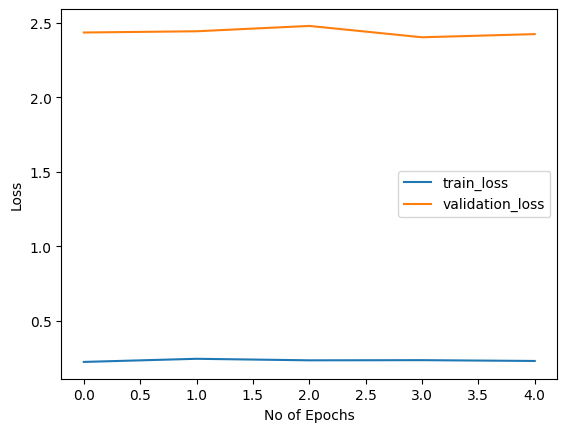

In [ ]:
plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy

In [ ]:
def accuracy(loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to("cpu"), targets.to("cpu")

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [ ]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

In [ ]:
print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.7097966728280961
Test Accuracy : 0.7422680412371134
Validation Accuracy : 0.7081545064377682


In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_targets = []
    n_correct = 0
    n_total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to("cpu"), targets.to("cpu")

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_preds.extend(predictions.tolist())
            all_targets.extend(targets.tolist())

            n_correct += (predictions == targets).sum().item()
            n_total += targets.size(0)

    # Calculate metrics
    acc = n_correct / n_total
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    return acc, precision, recall, f1


test_acc, test_prec, test_recall, test_f1 = evaluate_model(model, test_loader)


print(f"Testing Accuracy: {test_acc:.4f}")
print(f"Testing Precision: {test_prec:.4f}")
print(f"Testing Recall: {test_recall:.4f}")
print(f"Testing F1 Score: {test_f1:.4f}")


Testing Accuracy: 0.7423
Testing Precision: 0.7708
Testing Recall: 0.7561
Testing F1 Score: 0.7158


In [ ]:
single_prediction("test_images/peach_healthy.JPG")

In [ ]:
single_prediction("test_images/pepper_bacterial_spot.JPG")

In [ ]:
single_prediction("test_images/pepper_bell_healthy.JPG")

In [ ]:
single_prediction("test_images/potato_early_blight.JPG")

In [ ]:
single_prediction("test_images/potato_healthy.JPG")

In [ ]:
single_prediction("test_images/potato_late_blight.JPG")

In [ ]:
single_prediction("test_images/raspberry_healthy.JPG")

In [ ]:
single_prediction("test_images/soyaben healthy.JPG")

In [ ]:
single_prediction("test_images/potato_late_blight.JPG")

In [ ]:
single_prediction("test_images/squash_powdery_mildew.JPG")

In [ ]:
single_prediction("test_images/strawberry_healthy.JPG")

In [ ]:
single_prediction("test_images/strawberry_leaf_scorch.JPG")

In [ ]:
single_prediction("test_images/tomato_bacterial_spot.JPG")

In [ ]:
single_prediction("test_images/tomato_early_blight.JPG")

In [ ]:
single_prediction("test_images/tomato_healthy.JPG")

In [ ]:
single_prediction("test_images/tomato_late_blight.JPG")

In [ ]:
single_prediction("test_images/tomato_leaf_mold.JPG")

In [ ]:
single_prediction("test_images/tomato_mosaic_virus.JPG")

In [ ]:
single_prediction("test_images/tomato_septoria_leaf_spot.JPG")

In [ ]:
single_prediction("test_images/tomato_spider_mites_two_spotted_spider_mites.JPG")

In [ ]:
single_prediction("test_images/tomato_target_spot.JPG")

In [ ]:
single_prediction("test_images/tomato_yellow_leaf_curl_virus.JPG")